#**install and imports**

In [ ]:
!pip install finta oandapyV20

     |████████████████████████████████| 51 kB 278 kB/s 
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=70037 sha256=164a7c5ef72208842fac7730e39e830c4b58cc49e0e8a620ea0c14acbd568179
  Stored in directory: /root/.cache/pip/wheels/92/bd/c8/f003f96afcd47c2f94db568cf69d5834fd044897ced995babe
Successfully built oandapyV20


In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

import pickle

from finta import TA

import oandapyV20
import oandapyV20.endpoints.instruments as instruments

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import concatenate
from keras.preprocessing.sequence import TimeseriesGenerator

#**Load Data**

In [ ]:
accountID = ""
access_token = ""

client = oandapyV20.API(access_token=access_token)

In [ ]:
def get_data(symbol, timeframe, count):
    params = {"count": count, "granularity": timeframe}
    r = instruments.InstrumentsCandles(instrument=symbol, params=params)
    client.request(r)
    candles = r.response['candles']

    df = pd.json_normalize(candles)
    close = df['mid.c'].astype('float64').dropna()
    df['log_returns'] = np.log(1 + close.pct_change())
    df['Close'] = close
    df['Date'] = pd.to_datetime(df['time']).dt.tz_localize(None)
    df = df[['Date' , 'log_returns' , 'Close']]

    df.fillna(0, inplace=True)
    return df

In [ ]:
pair = 'XAU_USD'
timeframe = 'M5'
count = 5000

df = get_data(pair , timeframe, count)

In [ ]:
df = df[1:]

In [ ]:
df.tail()

,Date,log_returns,Close
4995,2021-09-23 12:00:00,-0.000008,1773.236
4996,2021-09-23 12:05:00,-0.000522,1772.310
4997,2021-09-23 12:10:00,0.000544,1773.275
4998,2021-09-23 12:15:00,0.000155,1773.550
4999,2021-09-23 12:20:00,-0.000682,1772.340


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3db7a4c250>,
      dtype=object)

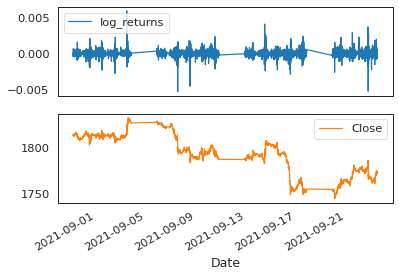

In [ ]:
df.set_index('Date').plot(subplots = True)

In [ ]:
X = df[['log_returns']].values

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

In [ ]:
y = [x[0] for x in X_scaled]

#**Spilit the data**

In [ ]:
spilit = int(len(X_scaled) * 0.8)

In [ ]:
X_train = X_scaled[:spilit]
X_test = X_scaled[spilit:len(X_scaled)]
y_train = y[:spilit]
y_test = y[spilit:len(y)]

#**Labaling**

In [ ]:
n = 60
Xtrain = []
Xtest = []
ytrain = []
ytest = []

for i in range(n , len(X_train)):
  Xtrain.append(X_train[i - n :i ,:X_train.shape[1]])
  ytrain.append(y_train[i])  
for i in range(n , len(X_test)):
  Xtest.append(X_test[i - n:i, : X_test.shape[1]])
  ytest.append(y_test[i])  

In [ ]:
Xtrain , ytrain = (np.array(Xtrain) , np.array(ytrain))
Xtrain = np.reshape(Xtrain , (Xtrain.shape[0] , Xtrain.shape[1] , Xtrain.shape[2]))

Xtest , ytest = (np.array(Xtest) , np.array(ytest))
Xtest = np.reshape(Xtest , (Xtest.shape[0] , Xtest.shape[1] , Xtest.shape[2]))

#**Train Model**

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(Xtrain.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(Xtrain.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

history = model.fit(Xtrain , ytrain, epochs=10, validation_data=(Xtest , ytest), verbose=1, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 60, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

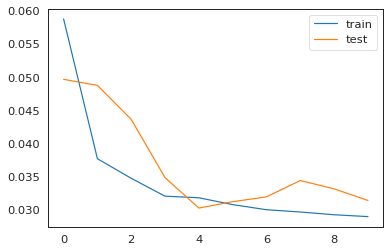

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
model.save('LSTM_FOREX.h5')

#**Forecast**

In [ ]:
last60candles = X_scaled[-61:-1, : 1]

In [ ]:
last60candles = np.reshape(last60candles , (1 , last60candles.shape[0] , last60candles.shape[1]))

In [ ]:
prediction = model.predict(last60candles)

In [ ]:
prediction = scaler.inverse_transform(prediction[0].reshape(-1,1))
prediction = [x[0] for x in prediction]
prediction = np.array(prediction).mean()

In [ ]:
prediction

-0.005358588

In [ ]:
df["Close"]

KeyError: ignored